In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import packages

In [2]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import ensemble
from xgboost import XGBClassifier
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Load dataset

In [4]:
train = pd.read_csv('drive/MyDrive/Colab Notebooks/fashion-mnist_train.csv')
test = pd.read_csv('drive/MyDrive/Colab Notebooks/fashion-mnist_test.csv')

In [5]:
df_train = train.copy()
df_test = test.copy()

# Examine NaN values

In [6]:
df_train.isnull().any().sum()

0

In [7]:
df_test.isnull().any().sum()

0

# Separating data and label

In [8]:
X_train= df_train.drop(['label'],axis = 1)
y_train = df_train['label']
X_test = df_test.drop(['label'], axis=1)
y_test = df_test['label']  # y_test should be labels

# Normalization
The Pixel Values are often stored as Integer Numbers in the range 0 to 255, the range that a single 8-bit byte can offer. They need to be scaled down to [0,1] in order for Optimization Algorithms to work much faster. Here, we acheive Zero Mean and Unit Variance.

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')  # X_test should be features
X_train /= 255.0
X_test /= 255.0  # X_test should be features

# Dimensionality Reduction using PCA
The advantage of PCA (and dimensionality reduction in general) is that it compresses the data down to something that is more effectively modeled. This means that it will, for example, compress away highly correlated and colinear variables, a useful thing to do when trying to run models that would otherwise be sensitive to these sort of data problems.

In [10]:
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  # Apply PCA transform to test data

# Evaluate the model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

seed = 42

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'learning_rate': uniform(0.01, 0.6),
    'max_depth': randint(low=1, high=10),
    'min_child_weight': randint(low=1, high=10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.1, 0.9),
    'colsample_bytree': uniform(0.1, 0.9)
}

rnd_search = RandomizedSearchCV(XGBClassifier(random_state=seed), param_distributions=param_distribs,
                                n_iter=10, cv=5, random_state=seed)
rnd_search.fit(X_train_pca, y_train)

print(rnd_search.best_params_)


{'colsample_bytree': 0.7545447962707788, 'gamma': 0.1632703844029177, 'learning_rate': 0.3522663846432396, 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 82, 'subsample': 0.5857229191501718}


In [11]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

seed = 42

# 최적의 하이퍼파라미터를 적용하여 모델 학습
xgb_optimized = XGBClassifier(n_estimators=82, learning_rate=0.3522663846432396, max_depth=9, min_child_weight=8, gamma=0.1632703844029177, subsample=0.5857229191501718, colsample_bytree=0.7545447962707788, random_state=seed)
xgb_optimized.fit(X_train_pca, y_train)

# 테스트 데이터에 대한 예측 수행
y_test_pred = xgb_optimized.predict(X_test_pca)

# 정확도 계산

test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

# 정확도 출력
print("Test Accuracy score: {}".format(test_accuracy))

# 분류 리포트 출력
print(metrics.classification_report(y_test, y_test_pred))

Test Accuracy score: 0.8852
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.80      0.81      1000
           3       0.90      0.91      0.91      1000
           4       0.81      0.84      0.82      1000
           5       0.96      0.94      0.95      1000
           6       0.71      0.67      0.69      1000
           7       0.93      0.94      0.93      1000
           8       0.96      0.97      0.97      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.88      0.89      0.88     10000
weighted avg       0.88      0.89      0.88     10000



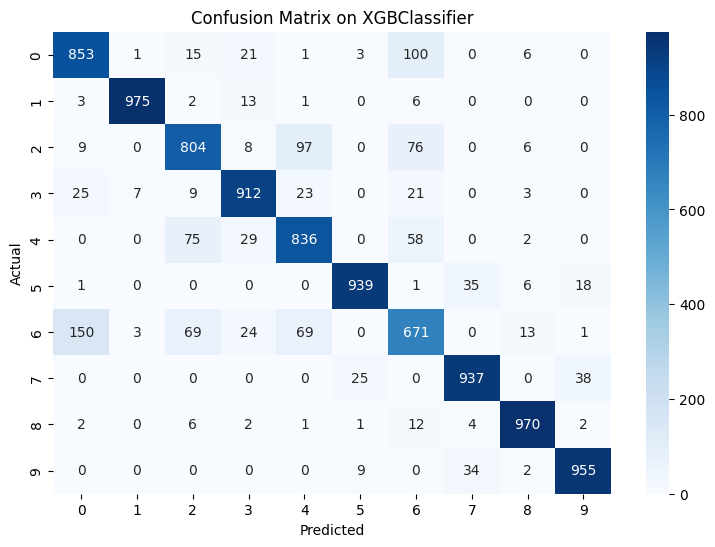

In [12]:
# 혼동 행렬(confusion matrix) 생성 및 시각화
con_matrix = pd.crosstab(pd.Series(y_test.values.flatten(), name='Actual'), pd.Series(y_test_pred, name='Predicted'))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on XGBClassifier")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.show()
